## Problem definition
The company wants to optimize the performance of its database. Some queries are slower than the others. And the task is to develop a ML model to predict query time using query text.

## Understanding the data - Exploratory Data Analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

### Two dataset are given. Let's start with the general logs

In [2]:
df_general = pd.read_json("./sql-analytics-problem-master/data/general_log.json")
df_general.shape #(16101, 6)
df_general.head()


,event_time,user_host,thread_id,server_id,command_type,argument
0,2021-01-14 15:19:54.549896,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ select...
1,2021-01-14 15:19:54.489750,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...
2,2021-01-14 15:19:54.430215,guest[guest] @ [185.9.209.177],67,97408076,Query,SHOW WARNINGS
3,2021-01-14 15:19:54.369984,guest[guest] @ [185.9.209.177],67,97408076,Query,SHOW WARNINGS
4,2021-01-14 15:19:54.310359,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ select...


In [3]:
# check datatypes
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16101 entries, 0 to 16100
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_time    16101 non-null  datetime64[ns]
 1   user_host     16101 non-null  object        
 2   thread_id     16101 non-null  int64         
 3   server_id     16101 non-null  int64         
 4   command_type  16101 non-null  object        
 5   argument      16101 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 754.9+ KB


In [4]:
df_general = df_general.sort_values(by="event_time", ascending=False)
last_general = df_general["event_time"].max() # last query time
first_general = df_general["event_time"].min() # first query time
time_delta_general = (last_general - first_general) # dif between first and last query
total_seconds_general = time_delta_general.total_seconds()
total_time_in_hours_general = total_seconds_general/(60*60)
print(f"This is a {total_time_in_hours_general:.2f} hour period")
print(f"Starting at - (first query time)  {first_general.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Ends at  - (last query time)    {last_general.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total number of queries {len(df_general)}")

This is a 3.98 hour period
Starting at - (first query time)  2021-01-14 11:20:54
Ends at  - (last query time)    2021-01-14 15:19:54
Total number of queries 16101


Lets see the time differences between requests

In [5]:
df_general["time_dif"] = (df_general["event_time"]
                            .diff(-1)
                            .apply(lambda x: x/np.timedelta64(1, 'ns'))
                            .fillna(0)
                            .astype('int64'))
# df_general.info() make sure time dif is int

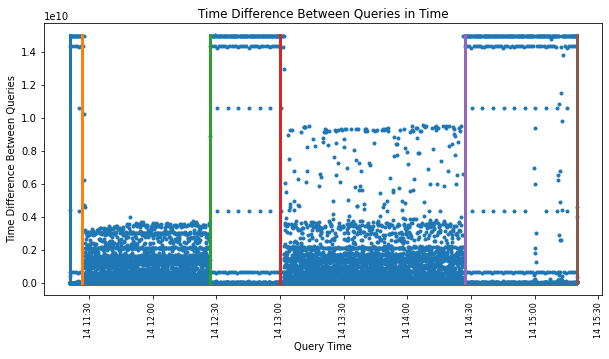

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_general.event_time.values, 
            df_general.time_dif.values, 
            marker= ".")
ax.set_ylabel("Time Difference Between Queries")
ax.set_xlabel("Query Time")
ax.set_title("Time Difference Between Queries in Time")
plt.xticks(rotation =90, fontsize=8)

max_point = df_general["time_dif"].max()
t1 = pd.to_datetime("2021-01-14 11:27:00")
t2 = pd.to_datetime("2021-01-14 12:27:00")
t3 = pd.to_datetime("2021-01-14 13:00:00")
t4 = pd.to_datetime("2021-01-14 14:27:00")

ax.plot([first_general, first_general], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t1, t1], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t2, t2], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t3, t3], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t4, t4], [0, max_point], linewidth=3, linestyle="-")
ax.plot([last_general, last_general], [0, max_point], linewidth=3, linestyle="-")

plt.show(fig)

Let's see the number of queries per second in those high hours

In [7]:
ts = [first_general, t1, t2, t3, t4, last_general]
def number_of_query(df, first, t1, t2, t3, t4, last, col):
    df_show = pd.DataFrame(columns = ["Time Start", "Time End", "Number of query", "Number of query per second"])
    for i in range(len(ts)-1):
        mask = (df[col]>ts[i]) & (df[col]<ts[i+1])
        new_ind = len(df_show) + 1
        df_show.loc[new_ind, :] = ts[i].strftime('%H:%M:%S'), ts[i+1].strftime('%H:%M:%S'), sum(mask), f"{(sum(mask)/(t1-first).total_seconds()):.3f}"
    return df_show

df_query_per_second = number_of_query(df_general, first_general, t1, t2, t3, t4, last_general, col="event_time")
df_query_per_second

,Time Start,Time End,Number of query,Number of query per second
1,11:20:54,11:27:00,247,0.676
2,11:27:00,12:27:00,5604,15.333
3,12:27:00,13:00:00,1325,3.625
4,13:00:00,14:27:00,6659,18.219
5,14:27:00,15:19:54,2264,6.194


It is obvious that in certain periods times between queries and number of queries are high. As seen above in **11:27 - 12:27** and **13:00 - 14:27** are very high hours 

### Frequency Plot for time between queries

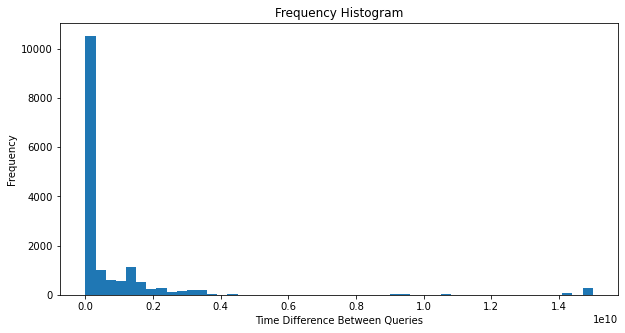

In [8]:
time_bt_query = df_general["time_dif"].values
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(time_bt_query, bins=50)
ax.set_xlabel("Time Difference Between Queries")
ax.set_ylabel("Frequency")
ax.set_title('Frequency Histogram')
plt.show()

### Slow queries

In [9]:
df_slow = pd.read_json("./sql-analytics-problem-master/data/slow_log.json")
df_slow.shape #(15688, 12)
df_slow.head()

,start_time,user_host,query_time,lock_time,rows_sent,rows_examined,db,last_insert_id,insert_id,server_id,sql_text,thread_id
0,2021-01-14 15:11:51.815988,guest[guest] @ [185.9.209.177],2021-05-17 00:00:00.000093,2021-05-17,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET ne...,67
1,2021-01-14 15:11:51.749969,guest[guest] @ [185.9.209.177],2021-05-17 00:00:00.000055,2021-05-17,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
2,2021-01-14 15:11:51.687122,guest[guest] @ [185.9.209.177],2021-05-17 00:00:00.000076,2021-05-17,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
3,2021-01-14 15:11:51.623647,guest[guest] @ [185.9.209.177],2021-05-17 00:00:00.000138,2021-05-17,1,1,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ select...,67
4,2021-01-14 15:11:51.562513,guest[guest] @ [185.9.209.177],2021-05-17 00:00:00.000090,2021-05-17,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET SQ...,67


In [10]:
df_slow = df_slow.sort_values(by="start_time", ascending=False)
last_slow = df_slow["start_time"].max()
first_slow = df_slow["start_time"].min()
time_delta_slow = (last_slow - first_slow)
total_seconds_slow = time_delta_slow.total_seconds()
total_time_in_hours_slow = total_seconds_slow/(60*60)
print(f"This is a {total_time_in_hours_slow:.2f} hour period")
print(f"Starting at  {first_slow.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Ends at      {last_slow.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total number of queries {len(df_general)}")

This is a 3.85 hour period
Starting at  2021-01-14 11:20:54
Ends at      2021-01-14 15:11:51
Total number of queries 16101


In [11]:
# turn query times into integer values
t_day = df_slow["query_time"][0]
t_day = pd.to_datetime(t_day.strftime('%Y-%m-%d'))

# t2 = pd.to_datetime("2021-05-10")
df_slow["query_time_ns"] = (df_slow["query_time"]
                            .apply(lambda x: (x - t_day).total_seconds()*1000000)
                            )

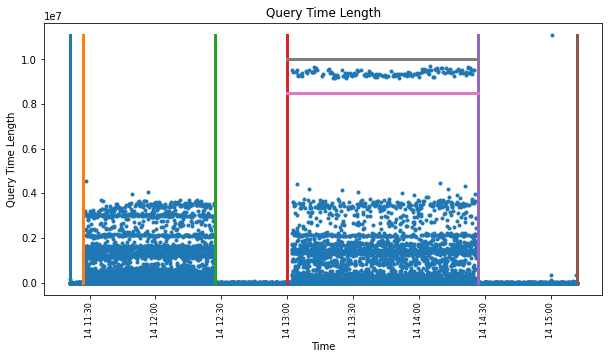

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_slow.start_time.values, 
            df_slow.query_time_ns.values, 
            marker= ".")
ax.set_ylabel("Query Time Length")
ax.set_xlabel("Time")
ax.set_title("Query Time Length")
plt.xticks(rotation =90, fontsize=8)

max_point = df_slow["query_time_ns"].max()
t1 = pd.to_datetime("2021-01-14 11:27:00")
t2 = pd.to_datetime("2021-01-14 12:27:00")
t3 = pd.to_datetime("2021-01-14 13:00:00")
t4 = pd.to_datetime("2021-01-14 14:27:00")

ax.plot([first_slow, first_slow], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t1, t1], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t2, t2], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t3, t3], [0, max_point], linewidth=3, linestyle="-")
ax.plot([t4, t4], [0, max_point], linewidth=3, linestyle="-")
ax.plot([last_slow, last_slow], [0, max_point], linewidth=3, linestyle="-")

ax.plot([t3, t4], [8.5e6, 8.5e6], linewidth=3, linestyle="-")
ax.plot([t3, t4], [10e6, 10e6], linewidth=3, linestyle="-")

plt.show(fig)

In [13]:
ts = [first_slow, t1, t2, t3, t4, last_slow]
df_query_per_second = number_of_query(df_slow, first_slow, t1, t2, t3, t4, last_slow, col="start_time")
df_query_per_second

,Time Start,Time End,Number of query,Number of query per second
1,11:20:54,11:27:00,246,0.673
2,11:27:00,12:27:00,5593,15.310
3,12:27:00,13:00:00,1318,3.608
4,13:00:00,14:27:00,6642,18.182
5,14:27:00,15:11:51,1887,5.165


### Investigation of extreme query times
This information will be used to remove outliers

In [14]:
summary = df_slow["query_time_ns"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])
summary

count    1.568800e+04
mean     5.464548e+05
std      1.211287e+06
min      7.000000e+00
10%      7.800000e+01
20%      1.630000e+02
30%      4.841000e+02
40%      7.420000e+02
50%      1.310500e+03
60%      6.946300e+04
70%      2.673571e+05
80%      1.158366e+06
90%      1.685535e+06
95%      2.834869e+06
99%      4.166627e+06
100%     1.107342e+07
max      1.107342e+07
Name: query_time_ns, dtype: float64

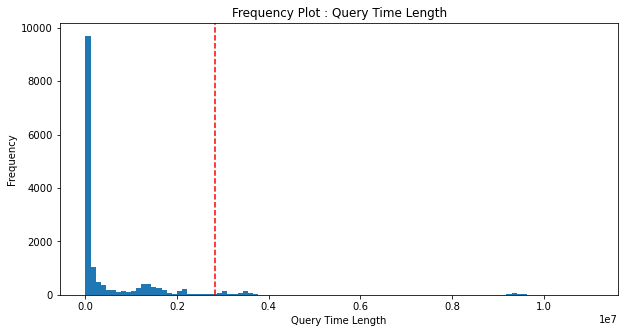

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df_slow["query_time_ns"], bins=100)
ax.set_xlabel("Query Time Length")
ax.set_ylabel("Frequency")
ax.set_title('Frequency Plot : Query Time Length')
ax.axvline(x=summary["95%"], c="r", linestyle="--")
plt.show()